In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Embedding, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing import sequence

# from TransformerComplet import *

from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, Concatenate, MultiHeadAttention



In [2]:
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

class Encodeur(tf.keras.layers.Layer):
    def __init__(self, n_layers, d_model, num_heads, middle_units,
                 max_seq_len, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
        super(Encodeur, self).__init__(**kwargs)
        self.n_layers = n_layers

        self.embedding_position = EncodagePosition(sequence_len=max_seq_len, embedding_dim=d_model)
        self.couche_encode = [CoucheEncodeur(d_model=d_model, num_heads=num_heads,max_seq_len=max_seq_len,
                                            middle_units=middle_units,
                                            epsilon=epsilon, dropout_rate=dropout_rate,
                                            training=training)
                             for _ in range(n_layers)]

    def call(self, inputs, **kwargs):
        emb, masque = inputs
        emb = self.embedding_position(emb)
        for i in range(self.n_layers):
            emb = self.couche_encode[i](emb, masque)

        return emb


# Couche d'encodage
class CoucheEncodeur(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, max_seq_len, middle_units, epsilon=1e-6, dropout_rate=0.1, training=False, **kwargs):
        super(CoucheEncodeur, self).__init__(**kwargs)

        self.mha = AttentionMultiTete(num_heads)
        # self.ffn = reseau_transformation_point_a_point(d_model + max_seq_len, middle_units) ## Erreur de Dimension
        self.ffn = reseau_transformation_point_a_point(d_model, middle_units)

        self.layernorm1 = NormalisationCouche()
        self.layernorm2 = NormalisationCouche()

        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)

        self.training = training

    def call(self, inputs, masque, **kwargs):
        # Réseau d'attention multi-tête
        sortie_att = self.mha([inputs, inputs, inputs, masque])
        sortie_att = self.dropout1(sortie_att, training=self.training)
        out1 = self.layernorm1(inputs + sortie_att)

        # Réseau de transformation point à point
        sortie_ffn = self.ffn(out1)
        sortie_ffn = self.dropout2(sortie_ffn, training=self.training)
        out2 = self.layernorm2(out1 + sortie_ffn)  # Problème de dimension ici

        return out2

# Normalisation de couche
class NormalisationCouche(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        self.eps = epsilon
        super(NormalisationCouche, self).__init__(**kwargs)

    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=tf.ones_initializer(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=tf.zeros_initializer(), trainable=True)
        super(NormalisationCouche, self).build(input_shape)

    def call(self, x):
        moyenne = tf.keras.backend.mean(x, axis=-1, keepdims=True)
        ecart_type = tf.keras.backend.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - moyenne) / (ecart_type + self.eps) + self.beta

    def compute_output_shape(self, input_shape):
        return input_shape


# Réseau de transformation point à point
def reseau_transformation_point_a_point(numUnits, middle_units):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(middle_units, activation='relu'),
        tf.keras.layers.Dense(numUnits, activation='relu')])


# Attention à produit scalaire équilibrée
def attention_produit_scalaire_equilibre(q, k, v, masque):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dim_k = tf.cast(tf.shape(k)[-1], tf.float32)
    attention_logits_mis_a_echelle = matmul_qk / tf.math.sqrt(dim_k)
    if masque is not None:
        attention_logits_mis_a_echelle += (masque * -1e9)

    poids_attention = tf.nn.softmax(attention_logits_mis_a_echelle, axis=-1)
    sortie = tf.matmul(poids_attention, v)
    return sortie


# Construction de la couche d'attention multi-tête
class AttentionMultiTete(tf.keras.layers.Layer):
    def __init__(self, num_heads, **kwargs):
        super(AttentionMultiTete, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention_produit_scalaire = attention_produit_scalaire_equilibre

    def separation_tetes(self, x, batch_size, profondeur):
        # Séparation des têtes, déplace la dimension du nombre de têtes avant la séquence
        x = tf.reshape(x, (batch_size, -1, self.num_heads, profondeur))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, **kwargs):
        q, k, v, masque = inputs
        batch_size = tf.shape(q)[0]
        numUnits = q.get_shape().as_list()[-1]
        profondeur = numUnits // self.num_heads

        # Avant la séparation des têtes, réseau avant la séparation
        wq = tf.keras.layers.Dense(numUnits)
        wk = tf.keras.layers.Dense(numUnits)
        wv = tf.keras.layers.Dense(numUnits)
        q = wq(q)
        k = wk(k)
        v = wv(v)

        # Séparation des têtes
        q = self.separation_tetes(q, batch_size, profondeur)
        k = self.separation_tetes(k, batch_size, profondeur)
        v = self.separation_tetes(v, batch_size, profondeur)

        # À travers la couche d'attention à produit scalaire équilibré
        attention_mise_a_echelle = self.attention_produit_scalaire(q, k, v, masque)

        # Déplacement de la dimension "têtes multiples"
        attention_mise_a_echelle = tf.transpose(attention_mise_a_echelle, [0, 2, 1, 3])

        # Fusion de la dimension "têtes multiples"
        attention_concatenee = tf.reshape(attention_mise_a_echelle, (batch_size, -1, numUnits))

        # Couche entièrement connectée
        dense = tf.keras.layers.Dense(numUnits)
        sortie = dense(attention_concatenee)

        return sortie

# Fonction de masquage
def masque_remplissage(seq):
    # Obtenir les éléments de remplissage (paddings) égaux à 0
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # Élargir les dimensions pour la matrice d'attention
    return seq[:, np.newaxis, np.newaxis, :]  # (batch_size, 1, 1, seq_len)


# Encodage des positions
class EncodagePosition(tf.keras.layers.Layer):
    def __init__(self, sequence_len=None, embedding_dim=None, **kwargs):
        self.sequence_len = sequence_len
        self.embedding_dim = embedding_dim
        super(EncodagePosition, self).__init__(**kwargs)

    def call(self, inputs):
        if self.embedding_dim is None:
            self.embedding_dim = int(inputs.shape[-1])

        encodage_position = np.array([
            [pos / np.power(10000, 2. * i / self.embedding_dim) for i in range(self.embedding_dim)]
            for pos in range(self.sequence_len)])

        encodage_position[:, 0::2] = np.sin(encodage_position[:, 0::2])  # dim 2i
        encodage_position[:, 1::2] = np.cos(encodage_position[:, 1::2])  # dim 2i+1

        encodage_position = tf.cast(encodage_position, dtype=tf.float32)

        return encodage_position + inputs

    def compute_output_shape(self, input_shape):
        return input_shape



In [7]:
# ################# Sa marche mais ne pas executer ici ##############
# ##################################################################

# import pandas as pd
# import zipfile

# import os

# # Chemins vers les fichiers zip
# chemin_zip_attack = "Attacks.zip"
# chemin_zip_benin = "Benign.zip"

# # Vérifier si les fichiers zip existent
# if os.path.exists(chemin_zip_attack):
#     print(f"Le fichier {chemin_zip_attack} existe dans votre espace de travail.")
# else:
#     print(f"Le fichier {chemin_zip_attack} n'existe pas dans votre espace de travail.")

# if os.path.exists(chemin_zip_benin):
#     print(f"Le fichier {chemin_zip_benin} existe dans votre espace de travail.")
# else:
#     print(f"Le fichier {chemin_zip_benin} n'existe pas dans votre espace de travail.")


Le fichier Attacks.zip n'existe pas dans votre espace de travail.
Le fichier Benign.zip n'existe pas dans votre espace de travail.


In [ ]:
# #################### Sa marche mais ne pas executer #########################
# #############################################################################

# import zipfile

# # Chemin vers l'archive zip
# chemin_zip = "Benign.zip"

# # Ouvrir l'archive zip
# with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
#     # Lister tous les fichiers dans l'archive
#     fichiers = zip_ref.namelist()
#     print("Contenu de l'archive zip:")
#     print(fichiers)

#     # Extraire tous les fichiers dans un répertoire temporaire
#     zip_ref.extractall("temp")

# # Afficher les noms des fichiers extraits
# print("Fichiers extraits:")
# for dossier, sous_dossiers, fichiers in os.walk("temp"):
#     for fichier in fichiers:
#         print(os.path)


In [19]:
# #################### Sa marche mais ne pas executer #########################
# #############################################################################


# import zipfile
# import os

# # Chemin vers l'archive zip
# chemin_zip = "Benign.zip"

# # Créer un répertoire temporaire pour extraire les fichiers
# dossier_extraction = "extraction_temp"
# os.makedirs(dossier_extraction, exist_ok=True)

# # Ouvrir l'archive zip
# with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
#     # Extraire tous les fichiers dans le répertoire temporaire
#     zip_ref.extractall(dossier_extraction)

# # Afficher les noms des fichiers extraits
# print("Fichiers extraits:")
# for fichier in os.listdir(dossier_extraction):
#     print(os.path.join(dossier_extraction, fichier))


Fichiers extraits:
extraction_temp/Benign


In [24]:
# #################### Sa marche mais ne pas executer #########################
# #############################################################################

# import pandas as pd
# import zipfile
# import os
# import shutil

# # Chemin vers l'archive zip
# chemin_zip = "Benign.zip"

# # Fonction pour charger les fichiers CSV à partir de l'archive zip extraite
# def charger_csv(chemin_zip, sous_dossier):
#     dataframes = []  # Stocker les dataframes chargés à partir des fichiers CSV

#     with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
#         # Extraire tous les fichiers dans un sous-dossier temporaire
#         zip_ref.extractall("extraction_temp")

#     # Parcourir les fichiers extraits dans le sous-dossier spécifié
#     for fichier in os.listdir(os.path.join("extraction_temp", sous_dossier)):
#         chemin_fichier = os.path.join("extraction_temp", sous_dossier, fichier)
#         if fichier.endswith(".csv"):
#             df = pd.read_csv(chemin_fichier)
#             dataframes.append(df)

#     # Supprimer le sous-dossier temporaire après avoir chargé les fichiers CSV
#     shutil.rmtree(os.path.join("extraction_temp", sous_dossier))

#     # Concaténer tous les dataframes en un seul
#     merged_dataframe = pd.concat(dataframes, ignore_index=True)

#     return merged_dataframe

# # Appeler la fonction pour charger les fichiers CSV depuis l'archive zip
# merged_stateful_benign = charger_csv(chemin_zip, "Benign")
# merged_stateless_benign = charger_csv(chemin_zip, "Benign")

# # Afficher les premières lignes des données chargées pour vérification
# print("merged_stateful_benign:")
# print(merged_stateful_benign.head())

# print("\nmerged_stateless_benign:")
# print(merged_stateless_benign.head())


merged_stateful_benign:
                    timestamp  FQDN_count  subdomain_length  upper  lower  \
0  2020-11-22 10:52:54.331014        27.0              10.0    0.0   10.0   
1  2020-11-22 10:52:54.743949        27.0              10.0    0.0   10.0   
2  2020-11-22 10:52:55.154578        27.0              10.0    0.0   10.0   
3  2020-11-22 10:52:55.566957        24.0               7.0    0.0   10.0   
4  2020-11-22 10:52:55.927177        32.0               0.0   32.0    0.0   

   numeric   entropy  special  labels  labels_max  ...  distinct_ns  \
0     11.0  2.570417      6.0     6.0         7.0  ...          NaN   
1     11.0  2.481480      6.0     6.0         7.0  ...          NaN   
2     11.0  2.481480      6.0     6.0         7.0  ...          NaN   
3      8.0  2.054029      6.0     6.0         7.0  ...          NaN   
4      0.0  2.735132      0.0     1.0        32.0  ...          NaN   

  distinct_ip unique_country  unique_asn  distinct_domains  reverse_dns  \
0         N

In [23]:
# #################### Sa marche mais ne pas executer #########################
# #############################################################################


# # Chemin vers l'archive zip des attaques
# chemin_zip_attacks = "Attacks.zip"

# # Appeler la fonction pour charger les fichiers CSV depuis l'archive zip des attaques
# merged_stateful_attacks = charger_csv(chemin_zip_attacks, "Attacks")
# merged_stateless_attacks = charger_csv(chemin_zip_attacks, "Attacks")

# # Afficher les premières lignes des données chargées pour vérification
# print("merged_stateful_attacks:")
# print(merged_stateful_attacks.head())

# print("\nmerged_stateless_attacks:")
# print(merged_stateless_attacks.head())


merged_stateful_attacks:
                    timestamp  FQDN_count  subdomain_length  upper  lower  \
0  2020-11-22 20:45:17.503530        27.0              10.0    0.0   10.0   
1  2020-11-22 20:45:17.915968        26.0               9.0    0.0   10.0   
2  2020-11-22 20:45:18.326662        26.0               9.0    0.0   10.0   
3  2020-11-22 20:45:18.739300        27.0              10.0    0.0   10.0   
4  2020-11-22 20:45:19.149609        27.0              10.0    0.0   10.0   

   numeric   entropy  special  labels  labels_max  ...  distinct_ns  \
0     11.0  2.767195      6.0     6.0         7.0  ...          NaN   
1     10.0  2.742338      6.0     6.0         7.0  ...          NaN   
2     10.0  2.742338      6.0     6.0         7.0  ...          NaN   
3     11.0  2.570417      6.0     6.0         7.0  ...          NaN   
4     11.0  2.570417      6.0     6.0         7.0  ...          NaN   

  distinct_ip unique_country  unique_asn  distinct_domains  reverse_dns  \
0         

In [8]:
################ Bon Code ###############
#### charger et lire un dataset [.zip] sur coolab ####

import zipfile
import os
import pandas as pd

import shutil

# # Chemins vers les fichiers zip quand je suis sur google Coolab

# chemin_zip_heavy_attacks = "/content/AttacksHeavy.zip"
# chemin_zip_heavy_benign = "/content/BenignHeavy.zip"


# chemin_zip_light_attacks = "/content/AttacksLight.zip"
# chemin_zip_light_benign = "/content/BenignLight.zip"

# Chemins vers les fichiers zip En local

chemin_zip_heavy_attacks = "AttacksHeavy.zip"
chemin_zip_heavy_benign = "BenignHeavy.zip"


chemin_zip_light_attacks = "AttacksLight.zip"
chemin_zip_light_benign = "BenignLight.zip"


# Fonction pour extraire les fichiers zip
def extraire_zip(chemin_zip):
    with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
        zip_ref.extractall("extraction_temp")  # Extraire les fichiers zip dans un répertoire temporaire

# Fonction pour charger les fichiers CSV d'un type spécifique (stateful ou stateless)
def charger_concatener_donnees(sous_dossier, prefixe):
    # Lister tous les fichiers CSV dans le sous-dossier
    fichiers_csv = [f for f in os.listdir(f"extraction_temp/{sous_dossier}") if f.startswith(prefixe) and f.endswith('.csv')]
    # Lire chaque fichier CSV et le stocker dans une liste de DataFrames
    dataframes = [pd.read_csv(f"extraction_temp/{sous_dossier}/{f}") for f in fichiers_csv]
    # Concaténer les DataFrames en un seul
    return pd.concat(dataframes, ignore_index=True)

# Extraire les fichiers zip
extraire_zip(chemin_zip_heavy_attacks)
extraire_zip(chemin_zip_heavy_benign)

extraire_zip(chemin_zip_light_attacks)
extraire_zip(chemin_zip_light_benign)

########## Heavy ############

# Charger et concaténer les données stateful
stateful_heavy_attack_data = charger_concatener_donnees("AttacksHeavy", "stateful")
stateful_heavy_benign_data = charger_concatener_donnees("BenignHeavy", "stateful")

# Charger et concaténer les données stateless
stateless_heavy_attack_data = charger_concatener_donnees("AttacksHeavy", "stateless")
stateless_heavy_benign_data = charger_concatener_donnees("BenignHeavy", "stateless")


#### Light ###############

# Charger et concaténer les données stateful
stateful_light_attack_data = charger_concatener_donnees("AttacksLight", "stateful")
stateful_light_benign_data = charger_concatener_donnees("BenignLight", "stateful")

# Charger et concaténer les données stateless
stateless_light_attack_data = charger_concatener_donnees("AttacksLight", "stateless")
stateless_light_benign_data = charger_concatener_donnees("BenignLight", "stateless")



# Supprimer le répertoire temporaire après avoir terminé

# Vérifier si le répertoire temporaire existe
if os.path.exists("extraction_temp"):
    # Supprimer le répertoire temporaire et son contenu
    shutil.rmtree("extraction_temp")


# Maintenant, vous avez vos données prêtes à être utilisées


In [9]:
############## taille reelle #############

############## pareille que celui du troisieme papier #############

print("Taille Stateful Heavy attack puis Stateless Heavy attack")
print(stateful_heavy_attack_data.shape)
print(stateless_heavy_attack_data.shape)


print("Taille Stateful Bengin  heavy attack puis Stateless Begnin attack ")
print(stateful_heavy_benign_data.shape)
print(stateless_heavy_benign_data.shape)



############## taille reelle #############
print("Taille Stateful Heavy Light attacks puis Stateless Light")
print(stateful_light_attack_data.shape)
print(stateless_light_attack_data.shape)


print("Taille Stateful Bengin Light attack puis Stateless Begnin Light")
print(stateful_light_benign_data.shape)
print(stateless_light_benign_data.shape)

#### concatenation  sur axis = 1 ########

print(" cocncatenantion sur axis = 0 sur les y \n")
print(" Heavy attack")

heavy_attack = pd.concat([stateful_heavy_attack_data, stateless_heavy_attack_data], axis=0)
print(heavy_attack.shape)

#### j'ajoute la classe / label ######

heavy_attack['class'] = 'heavy_attacks'
print(heavy_attack.shape)

print(" \n")
print(" Heavy Bengnin")

heavy_bengin = pd.concat([stateful_heavy_benign_data, stateless_heavy_benign_data], axis=0)
print(heavy_bengin.shape)

#### j'ajoute la classe / label ######

heavy_bengin['class'] = 'heavy_bengnin'
print(heavy_bengin.shape)

print(" \n")
print(" Light attack")

light_attack = pd.concat([stateful_light_attack_data, stateless_light_attack_data], axis=0)
print(light_attack.shape)

#### j'ajoute la classe / label ######
light_attack['class'] = 'light_attacks'
print(light_attack.shape)


print(" \n")
print(" Light Bengnin")

light_bengin = pd.concat([stateful_light_benign_data, stateless_light_benign_data], axis=0)
print(light_bengin.shape)

#### j'ajoute la classe / label ######
light_bengin['class'] = 'light_bengnin'
print(light_bengin.shape)


Taille Stateful Heavy attack puis Stateless Heavy attack
(72028, 27)
(251670, 15)
Taille Stateful Bengin  heavy attack puis Stateless Begnin attack 
(69016, 27)
(181694, 15)
Taille Stateful Heavy Light attacks puis Stateless Light
(11295, 27)
(42683, 15)
Taille Stateful Bengin Light attack puis Stateless Begnin Light
(22768, 27)
(60091, 15)
 cocncatenantion sur axis = 0 sur les y 

 Heavy attack
(323698, 42)
(323698, 43)
 

 Heavy Bengnin
(250710, 42)
(250710, 43)
 

 Light attack
(53978, 42)
(53978, 43)
 

 Light Bengnin
(82859, 42)
(82859, 43)


In [25]:
# ############# Ne pas executer ########################
# ############ Ne pas executer ##########################
# ########## cocncatenantion sur axis = 1 ##############

# print(" cocncatenantion sur axis = 1 sur les x  \n")
# print(" Heavy attack")

# heavy_attack = pd.concat([stateful_heavy_attack_data, stateless_heavy_attack_data], axis=1)
# print(heavy_attack.shape)

# #### j'ajoute la classe / label ######

# heavy_attack['class'] = 'heavy attacks'
# print(heavy_attack.shape)

# print(" \n")
# print(" Heavy Bengnin")

# heavy_bengin = pd.concat([stateful_heavy_benign_data, stateless_heavy_benign_data], axis=1)
# print(heavy_bengin.shape)

# #### j'ajoute la classe / label ######

# heavy_bengin['class'] = 'heavy attacks'
# print(heavy_bengin.shape)


# print(" \n")
# print(" Light attack")

# light_attack = pd.concat([stateful_light_attack_data, stateless_light_attack_data], axis=1)
# print(light_attack.shape)

# #### j'ajoute la classe / label ######
# light_attack['class'] = 'light attacks'
# print(light_attack.shape)


# print(" \n")
# print(" Light Bengnin")

# light_bengin = pd.concat([stateful_light_benign_data, stateless_light_benign_data], axis=1)
# print(light_bengin.shape)

# #### j'ajoute la classe / label ######
# light_bengin['class'] = 'light bengnin'
# print(light_bengin.shape)

 cocncatenantion sur axis = 1 sur les x  

 Heavy attack
(251670, 42)
(251670, 43)
 

 Heavy Bengnin
(181694, 42)
(181694, 43)
 

 Light attack
(42683, 42)
(42683, 43)
 

 Light Bengnin
(60091, 42)
(60091, 43)


In [10]:

# #### Echantillonage comme dans le papier ayat produit ce dataset ####

# ##  Heavy Attack   72,028(stateful)      251,670 (stateless)

# ##  Heavy-Benign      156,014                  402,767

# ### Light Attack      11,295                   42,683

# ### Light-Benign      109,766                  281,164


# #### Heavy ATTACK #########
# stateful_heavy_attack_data = stateful_heavy_attack_data.sample(72028, random_state=42)
# stateful_heavy_benign_data = stateful_heavy_benign_data.sample(156014, random_state=42,replace=True)

# stateless_heavy_attack_data = stateless_heavy_attack_data.sample(251670, random_state=42)
# stateless_heavy_benign_data = stateless_heavy_benign_data.sample(402767, random_state=42,replace=True)

# #### Light ATTACK #########

# # Charger les données stateful
# stateful_light_attack_data = stateful_light_attack_data.sample(11295, random_state=42)
# stateful_light_benign_data = stateful_light_benign_data.sample(109766, random_state=42,replace=True)
# # Charger les données stateless
# stateless_light_attack_data = stateless_light_attack_data.sample(42683, random_state=42)
# stateless_light_benign_data = stateless_light_benign_data.sample(281164, random_state=42,replace=True)

# ############## taille apres re-echantillonage #############
# print("Taille Stateful Heavy attack puis Stateless Heavy attack")
# print(stateful_heavy_attack_data.shape)
# print(stateless_heavy_attack_data.shape)

# print("  \n")

# print("Taille Stateful Bengin attack puis Stateless Begnin attack ")
# print(stateful_heavy_benign_data.shape)
# print(stateless_heavy_benign_data.shape)

# print("  \n")


# ############## taille apres re-echantillonage #############
# print("Taille Stateful Heavy Light puis Stateless Light")
# print(stateful_light_attack_data.shape)
# print(stateless_light_attack_data.shape)

# print("  \n")

# print("Taille Stateful Bengin Light puis Stateless Begnin Light")
# print(stateful_light_benign_data.shape)
# print(stateless_light_benign_data.shape)

Taille Stateful Heavy attack puis Stateless Heavy attack
(72028, 27)
(251670, 15)
  

Taille Stateful Bengin attack puis Stateless Begnin attack 
(156014, 27)
(402767, 15)
  

Taille Stateful Heavy Light puis Stateless Light
(11295, 27)
(42683, 15)
  

Taille Stateful Bengin Light puis Stateless Begnin Light
(109766, 27)
(281164, 15)


In [ ]:
# ######################################################################################
# ######################################################################################
# ### Ne pas executer car ici c'es le cas d'une classification binaraire que je test ####
# ######################################################################################
# ######################################################################################


# ##### pharse de concatenation tres importante car les jeu de donnee n'ont pas tous les memes schemas ####


# ### (axis=0) car ils ont les memes colonnes donc ont empile ; (axis=1) colonne different on juxtapose

# merged_statful_heavy_light_attack = pd.concat([stateful_heavy_attack_data, stateful_light_attack_data], axis=0, ignore_index=True)
# merged_stateless_heavy_light_attack = pd.concat([stateless_heavy_attack_data, stateless_light_attack_data], axis=0, ignore_index=True)

# merged_statful_heavy_light_bengnin = pd.concat([stateful_heavy_benign_data, stateful_light_benign_data], axis=0, ignore_index=True)
# merged_stateless_heavy_light_bengnin = pd.concat([stateless_heavy_benign_data, stateless_light_benign_data], axis=0, ignore_index=True)




# ############## taille apres re-echantillonage  et Concatenantion #############
# print("Taille Stateful Heavy attack puis Stateless Light attacks ")
# print(merged_statful_heavy_light_attack.shape)
# print(merged_stateless_heavy_light_attack.shape)

# print("  \n")

# print("Taille Stateful Bengin Light puis Stateless Begnin Light")
# print(merged_statful_heavy_light_bengnin.shape)
# print(merged_stateless_heavy_light_bengnin.shape)

# print("  \n")




# # Fusionner les données stateful et stateless
# final_attack_data = pd.concat([merged_statful_heavy_light_attack, merged_stateless_heavy_light_attack], axis=1)
# final_benign_data = pd.concat([merged_statful_heavy_light_bengnin, merged_stateless_heavy_light_bengnin], axis=1)

# # Ajouter les étiquettes
# final_attack_data['label'] = 'attack heavy _light'
# final_benign_data['label'] = 'benign heavy _light'

# print(final_attack_data.shape)
# print(final_benign_data.shape)

# final_attack_data.isnull().sum().sort_values(ascending=False)
# final_benign_data.isnull().sum().sort_values(ascending=False)


# ##################################################################################################
# ########################## End ###################################################################
# ##################################################################################################



In [10]:
################################### CONCATENATION Final des donnee sur axis = 0 ########
########################################################################################
########################################################################################


# 2. Concaténer les données

final_data = pd.concat([heavy_attack, heavy_bengin,light_attack,light_bengin], axis=0, ignore_index=True)

# 3. Supprimer les colonnes redondantes dans les données catégorielles
final_data = final_data.loc[:, ~final_data.columns.duplicated()]

X_numerical = final_data.select_dtypes(include=['int64', 'float64'])

X_categorical = final_data.select_dtypes(exclude='number').drop('class', axis=1)
y = final_data['class']

print(X_numerical.shape)
print(X_categorical.shape)

print(y.shape)
print(final_data.shape)



(711245, 32)
(711245, 10)
(711245,)
(711245, 43)


In [ ]:
# ################################### CONCATENATION Final des donnee sur axis = 1 ########
# ########################################################################################
# ########################################################################################

# ############## Ne pas executer ,executer si et seulement si jai executer la concatenation sur axis =1 ####



# # 2. Concaténer les données

# final_data = pd.concat([heavy_attack, heavy_bengin,light_attack,light_bengin], axis=1, ignore_index=True)

# # 3. Supprimer les colonnes redondantes dans les données catégorielles
# final_data = final_data.loc[:, ~final_data.columns.duplicated()]

# X_numerical = final_data.select_dtypes(include=['int64', 'float64'])

# X_categorical = final_data.select_dtypes(exclude='number').drop('class', axis=1)
# y = final_data['class']

# print(X_numerical.shape)
# print(X_categorical.shape)

# print(y.shape)



In [11]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.impute import SimpleImputer


#prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

# 2. Vérification des colonnes vides
if X_numerical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques numériques
    numerical_imputer = SimpleImputer(strategy='mean')
    X_numerical_imputed = pd.DataFrame(numerical_imputer.fit_transform(X_numerical), columns=X_numerical.columns)

    #prepocessing des features numeriques soit  avec le  LabelEncoder soit le MinMaxScaler()

    # Création d'un scaler
    scaler = MinMaxScaler()

    # Ajustement du scaler aux données
    scaler.fit(X_numerical_imputed)

    scaled_numeric_features = scaler.transform(X_numerical_imputed)

    scaled_df = pd.DataFrame(scaled_numeric_features, columns=X_numerical.columns)


    # Afficher le DataFrame avec les valeurs transformées
    print("Après transformation")
    print(scaled_df)

    total_size = scaled_df.shape

    print("Taille totale des caracteristiques numeriques apres concatenations :", total_size)

else:
    print("Pas de valeurs manquantes dans les caractéristiques numériques. Aucune imputation nécessaire.")

Après transformation
             rr  A_frequency  NS_frequency  CNAME_frequency  SOA_frequency   
0       0.00000     0.000000           0.0              0.0            0.0  \
1       0.00000     0.000000           0.0              0.0            0.0   
2       0.00000     0.000000           0.0              0.0            0.0   
3       0.00000     0.000000           0.0              0.0            0.0   
4       0.00000     0.000000           0.0              0.0            0.0   
...         ...          ...           ...              ...            ...   
711240  0.07015     0.070149           0.0              0.0            0.0   
711241  0.07015     0.070149           0.0              0.0            0.0   
711242  0.07015     0.070149           0.0              0.0            0.0   
711243  0.07015     0.070149           0.0              0.0            0.0   
711244  0.07015     0.070149           0.0              0.0            0.0   

        NULL_frequency  PTR_frequency  HIN

In [12]:
from sklearn.impute import SimpleImputer

# Vérification des colonnes vides
if X_categorical.isnull().any().any():
    # Imputer les valeurs manquantes pour les caractéristiques catégorielles
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X_categorical_imputed = pd.DataFrame(categorical_imputer.fit_transform(X_categorical), columns=X_categorical.columns)

    # Afficher le DataFrame avec les valeurs imputées
    print("Après imputation")
    print(X_categorical_imputed)

    total_size_categorical = X_categorical_imputed.shape

    print("Taille totale des caractéristiques catégorielles après imputation :", total_size_categorical)

else:
    print("Pas de valeurs manquantes dans les caractéristiques catégorielles. Aucune imputation nécessaire.")


Après imputation
        rr_type distinct_ip unique_country unique_asn distinct_domains   
0       {'PTR'}       set()          set()      set()               {}  \
1         set()       set()          set()      set()               {}   
2       {'PTR'}       set()          set()      set()               {}   
3       {'PTR'}       set()          set()      set()               {}   
4       {'PTR'}       set()          set()      set()               {}   
...         ...         ...            ...        ...              ...   
711240  {'PTR'}       set()          set()      set()               {}   
711241  {'PTR'}       set()          set()      set()               {}   
711242  {'PTR'}       set()          set()      set()               {}   
711243  {'PTR'}       set()          set()      set()               {}   
711244  {'PTR'}       set()          set()      set()               {}   

       reverse_dns             unique_ttl                   timestamp   
0          unknown   

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd


X_copy = X_categorical_imputed.copy()


# Appliquer une tokenisation à chaque colonne catégorielle
for feature in X_categorical_imputed.columns.tolist():
    X_copy[feature] = X_copy[feature].astype(str)


# Combinez les colonnes catégorielles dans une colonne 'combined_text'

X_copy['combined_text'] = X_copy[X_categorical_imputed.columns.tolist()].apply(lambda row: ' '.join(row), axis=1)


# Tokenisation
tokenizer = Tokenizer(num_words=100, filters=' ', split=' ')
tokenizer.fit_on_texts(X_copy['combined_text'])
tokens = tokenizer.texts_to_sequences(X_copy['combined_text'])

# Calcul de la longueur maximale du vecteur
max_sequence_length = max(len(seq) for seq in tokens)


### PAS BESOIN D'EXECUTER CE CECI  CAR ma machine ne dispose pas d'assez de ressources #####

# Ajout des colonnes tokenisées au DataFrame
# for i in range(1, max_sequence_length + 1):
    # X_copy[f'token_{i}'] = [seq[i - 1] if len(seq) >= i else 0 for seq in tokens]

# Suppression des colonnes originales et la colonne temporaire 'combined_text'
# X_copy.drop(columns=X_categorical_imputed.columns.tolist() + ['combined_text'], inplace=True)

##################### End ##############################################

# Afficher les tokens et les longueurs de séquence
# print(tokens)


# Affichage de la longueur maximale
print(f"Longueur maximale du vecteur : {max_sequence_length}")


Longueur maximale du vecteur : 28


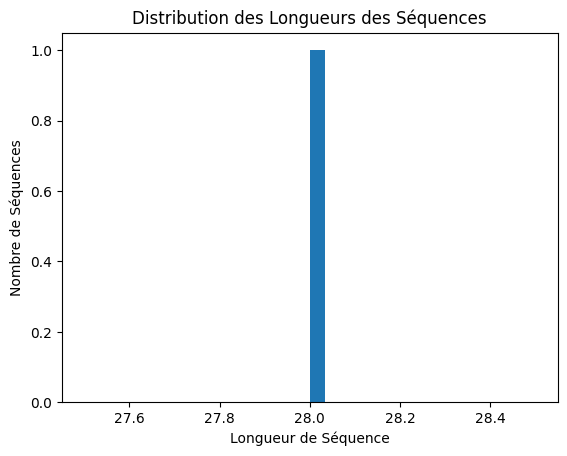

In [14]:
mean_length = np.mean(max_sequence_length)
max_length = np.max(max_sequence_length)
min_length = np.min(max_sequence_length)
std_dev = np.std(max_sequence_length)

# Visualisation de la distribution des longueurs des séquences
import matplotlib.pyplot as plt
plt.hist(max_sequence_length, bins=30)
plt.xlabel('Longueur de Séquence')
plt.ylabel('Nombre de Séquences')
plt.title('Distribution des Longueurs des Séquences')
plt.show()


In [15]:
# Hyperparamètres et dimensions des données*
taille_num_features = scaled_df.shape[1]
taille_text_features = max_sequence_length # je donne la taille max parmi les longueur des sequences
vocab_size = 20000 ### ici vu que j'utilise la tokenisation keras la taille du vocabulaires est en realaite le paramtre ['num_word] passer a mon tokeniser donc inutile cette ligne 
embedding_dim = 128

In [16]:
from tensorflow.keras.layers import *
import tensorflow as tf



# Entrées
input_num = tf.keras.layers.Input(shape=(taille_num_features,))
input_text = tf.keras.layers.Input(shape=(taille_text_features,))


# Branches du modèle
# Branche numérique - FFN

num_branch = tf.keras.layers.Dense(128, activation='relu')(input_num)
num_branch = tf.keras.layers.Dense(64, activation='relu')(num_branch)


# Branche textuelle - Embedding + Transformer (Un block)

text_branch = Embedding(vocab_size, embedding_dim, input_length=taille_text_features)(input_text)

mask_inputs = masque_remplissage(input_text)

num_blocks = 4
out_seq = text_branch  # Initialisation avec les embeddings
for _ in range(num_blocks):
    out_seq = Encodeur(
            n_layers=4,
            d_model=128,
            num_heads=8,
            middle_units=256,
            max_seq_len=taille_text_features)([text_branch, mask_inputs])
out_seq = GlobalAveragePooling1D()(out_seq)
out_seq = Dropout(0.3)(out_seq)

# Fusion des branches

flattened_text_branch = tf.keras.layers.Flatten()(text_branch) # je remodelise les dimension
merged = tf.keras.layers.concatenate([num_branch, flattened_text_branch])


# Couches supplémentaires après la fusion
merged = tf.keras.layers.Dropout(0.3)(merged)
merged = tf.keras.layers.Dense(16, activation='relu')(merged)

output = tf.keras.layers.Dense(4, activation='softmax')(merged)


# Création et compilation du modèle
model = Model(inputs=[input_num, input_text], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(model.summary())




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          4224        ['input_1[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 28, 128)      2560000     ['input_2[0][0]']                
                                                                                              

In [17]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Entrées pour l'entraînement
data_num = scaled_df
data_text = pad_sequences(tokens, maxlen=max_length,padding='post')

# Assurez-vous que les données numériques sont correctes
print("Shape of data_num:", data_num.shape)

# Assurez-vous que les données textuelles sont correctes après le rembourrage
print("Shape of data_text:", data_text.shape)

# Assurez-vous que les étiquettes sont correctes
print("Shape of labels:", y.shape)

# NB utiliser le resultat obtenu pour modifier les tailles ou dimension de mes entrées definie plus haut


# 6. Encodage des étiquettes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(y_encoded)

Shape of data_num: (711245, 32)
Shape of data_text: (711245, 28)
Shape of labels: (711245,)
[0 0 0 ... 3 3 3]


In [18]:
from sklearn.model_selection import train_test_split

# 7. Diviser les données en ensembles d'entraînement et de test
# X_train_numerical, X_test_numerical, X_train_categorical, X_test_categorical, y_train, y_test = train_test_split(data_num, data_text, y_encoded, test_size=0.25, random_state=42)

# history = model.fit([X_train_numerical,X_train_categorical], y_train, epochs=5, batch_size=64, validation_data=([X_test_numerical,X_test_categorical], y_test))



from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test (15% pour le test)
X_train_num, X_test_num, X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    data_num, data_text, y_encoded, test_size=0.15, random_state=42
)

# Diviser l'ensemble d'entraînement en sous-ensembles d'entraînement et de validation (15% pour la validation)
X_train_num, X_val_num, X_train_cat, X_val_cat, y_train, y_val = train_test_split(
    X_train_num, X_train_cat, y_train, test_size=0.15 / 0.85, random_state=42
)

# Entraîner le modèle avec les données d'entraînement et de validation
history = model.fit(
    [X_train_num, X_train_cat], y_train,
    epochs=10,
    batch_size=64,
    validation_data=([X_val_num, X_val_cat], y_val)
)


Train on 497871 samples, validate on 106687 samples
Epoch 1/10
497871/497871 [==============================] - ETA: 0s - loss: 0.5699 - accuracy: 0.7642

c:\python install\lib\site-packages\keras\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


497871/497871 [==============================] - 832s 2ms/sample - loss: 0.5699 - accuracy: 0.7642 - val_loss: 0.5432 - val_accuracy: 0.7684
Epoch 2/10
497871/497871 [==============================] - 819s 2ms/sample - loss: 0.5466 - accuracy: 0.7678 - val_loss: 0.5433 - val_accuracy: 0.7620
Epoch 3/10
497871/497871 [==============================] - 829s 2ms/sample - loss: 0.5454 - accuracy: 0.7679 - val_loss: 0.5445 - val_accuracy: 0.7684
Epoch 4/10
497871/497871 [==============================] - 834s 2ms/sample - loss: 0.5449 - accuracy: 0.7679 - val_loss: 0.5427 - val_accuracy: 0.7683
Epoch 5/10
119616/497871 [======>.......................] - ETA: 10:03 - loss: 0.5401 - accuracy: 0.7719

KeyboardInterrupt: 

In [61]:
from sklearn.metrics import classification_report


# Évaluation du modèle sur les données de test
evaluation_results = model.evaluate([X_test_numerical, X_test_categorical], y_test)

# print(f'Accuracy: {accuracy}, Loss: {loss}')
print("Perte sur les données de test:", evaluation_results[0])
print("Précision sur les données de test:", evaluation_results[1])

#on effectue les prediction sur les donnees de test

y_pred = model.predict([X_test_numerical, X_test_categorical])

print(y_pred)


# Convertir les indices des classes prédites en étiquettes
y_pred_classes = np.argmax(y_pred, axis=1)

# Afficher le rapport de classification
class_report = classification_report(y_test, y_pred_classes)
print("Rapport de classification :\n", class_report)


Perte sur les données de test: 0.8464497971491286
Précision sur les données de test: 0.6753481
[[6.4542019e-01 1.7392071e-01 9.9653259e-02 8.1005879e-02]
 [5.9802401e-01 2.5777960e-01 1.4419304e-01 3.3017816e-06]
 [6.7702752e-01 1.8230924e-01 8.4990405e-02 5.5672776e-02]
 ...
 [6.1012632e-01 2.5207373e-01 1.3779324e-01 6.6706871e-06]
 [6.7831016e-01 1.8200645e-01 8.4493130e-02 5.5190299e-02]
 [4.1251133e-05 6.9094253e-01 9.0505218e-06 3.0900720e-01]]


c:\python install\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\python install\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Rapport de classification :
               precision    recall  f1-score   support

           0       0.65      1.00      0.78     80888
           1       0.75      0.63      0.68     62650
           2       0.00      0.00      0.00     13543
           3       0.50      0.01      0.01     20731

    accuracy                           0.68    177812
   macro avg       0.47      0.41      0.37    177812
weighted avg       0.61      0.68      0.60    177812



c:\python install\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


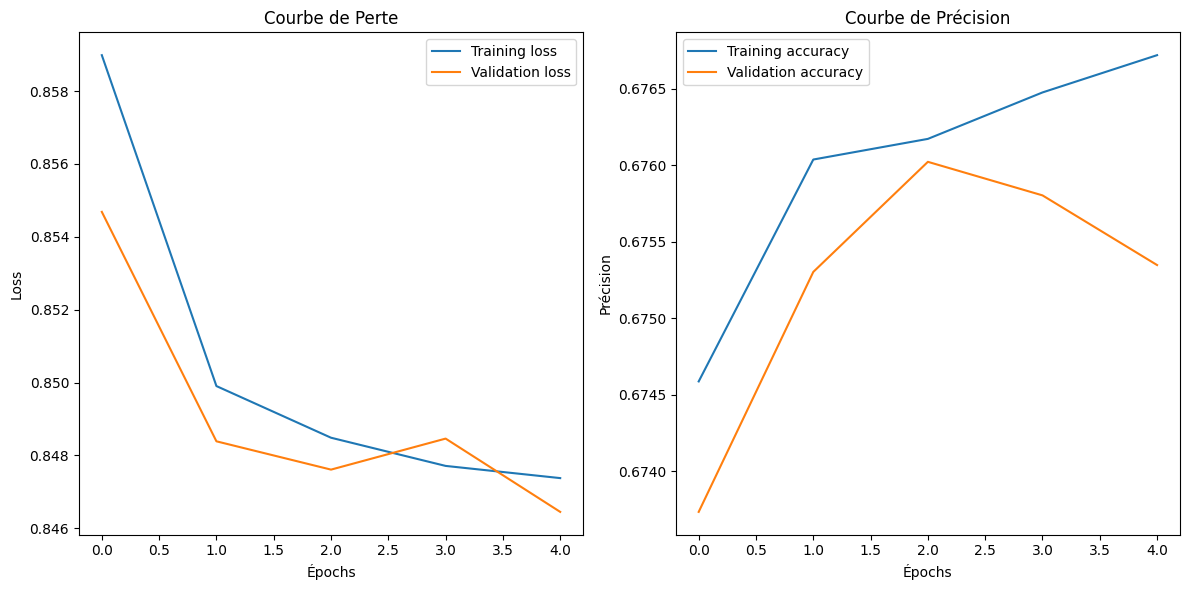

In [58]:
# Extraction des métriques d'entraînement
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Affichage des courbes de perte et d'exactitude séparément
epochs = range(1, len(loss) + 1)

# Affichage des courbes d'apprentissage et de validation
plt.figure(figsize=(12, 6))

# Plot de la perte d'entraînement et de la perte de validation
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Courbe de Perte')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.legend()


# Plot de la précision d'entraînement et de la précision de validation
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Courbe de Précision')
plt.xlabel('Épochs')
plt.ylabel('Précision')
plt.legend()

# Afficher les deux sous-plots
plt.tight_layout()
plt.show()

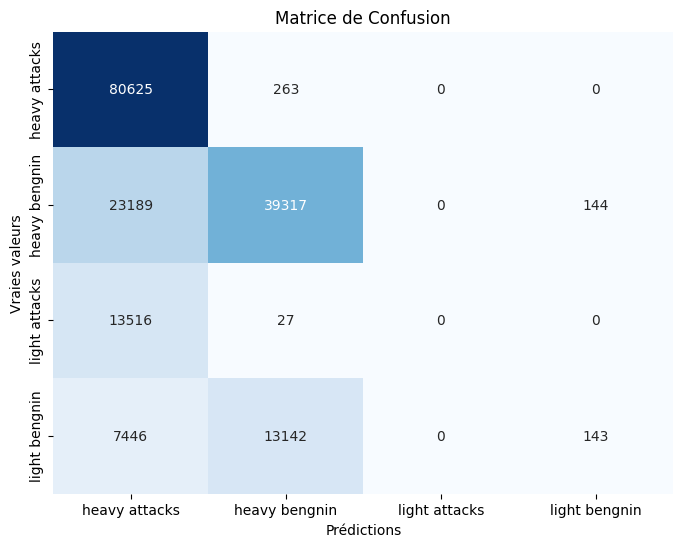

In [59]:
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, roc_curve, auc



# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_classes)
# class_names = ['heavy attacks', 'heavy bengnin', 'light attacks', 'light bengnin']

class_names = ['heavy_attacks', 'heavy_bengnin', 'light_attacks', 'light_bengnin']

df_cm = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Afficher la matrice de confusion avec seaborn
plt.figure(figsize=(8, 6))
sn.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies valeurs')
plt.show()